# Quantum computing code draft for SQL grammar to circuit

## Parsing

Parse the SQL queries from the examples folder. The queries are parsed with ANTRL framework which is extensive general-purpose parsing tool. We selected the SQLite grammar for its simplicity in ANTRL. Because the core features of SQL are the same for any relational database, this code does not depend on system dependent SQL ''dialects''.

In [1]:
from antlr4 import *
from SQLiteLexer import SQLiteLexer
from SQLiteParser import SQLiteParser
from SQLiteParserListener import SQLiteParserListener
import json

input_file = "examples/sql2.sql"

input = FileStream(input_file)
lexer = SQLiteLexer(input)
stream = CommonTokenStream(lexer)
parser = SQLiteParser(stream)
tree = parser.parse()

print("Whole parse tree: ")
print(tree.toStringTree(recog=parser))

Whole parse tree: 
(parse (sql_stmt_list (sql_stmt (select_stmt (select_core SELECT (result_column (expr (column_name (any_name rick)))) , (result_column (expr (column_name (any_name morty)))) FROM (table_or_subquery (table_name (any_name reality_1))) , (table_or_subquery (table_name (any_name reality_2))) WHERE (expr (expr (expr (column_name (any_name rick))) = (expr (literal_value 1000))) AND (expr (expr (column_name (any_name morty))) = (expr (literal_value 10)))))))) <EOF>)


## Diagrammatic representation of SQL language elements in context free grammar

We walk the tree and collect the elements in a monoidal category. This creates a diagrammatic representation for the parsed SQL query. `SQLiteParserListener` class implements DisCoPy construction. First we collect the abstract parse tree but we also modify it so that we collect SELECT and the columns into the same element, FROM and tables into the same element and WHERE and the filtering clauses into the same element. This interpretation follows the [railroad diagram representation](https://www.sqlite.org/syntaxdiagrams.html#select-core) more accurately than the current parsing. It also enables us to map the parse tree correctly later.

select_core_diagram


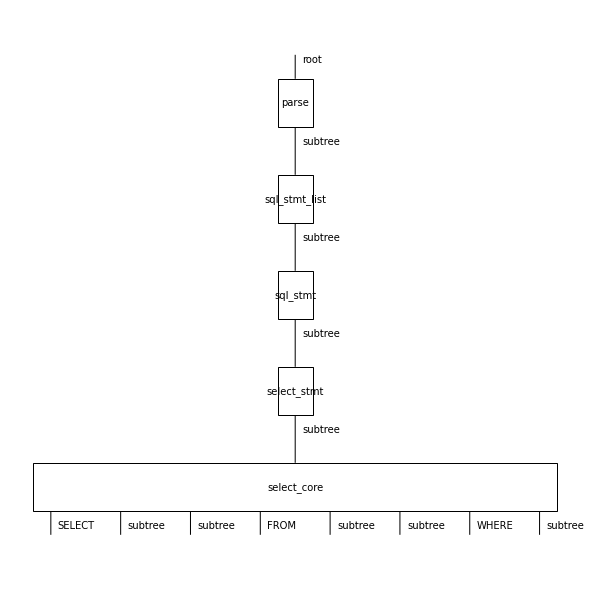

result_column_diagrams


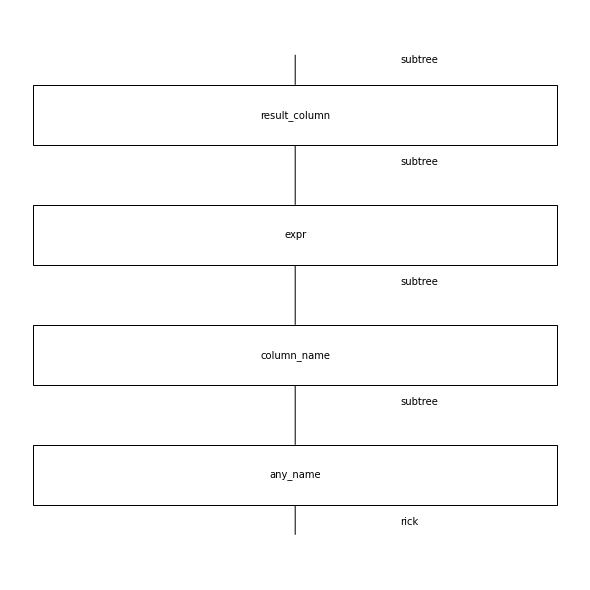

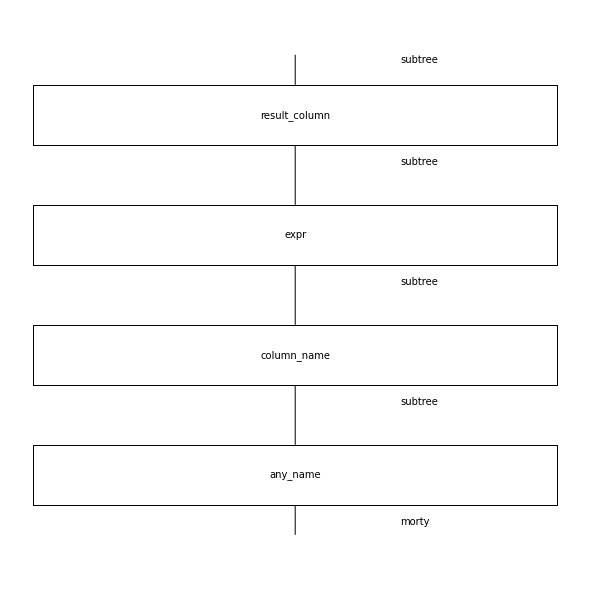

table_or_subquery_diagrams


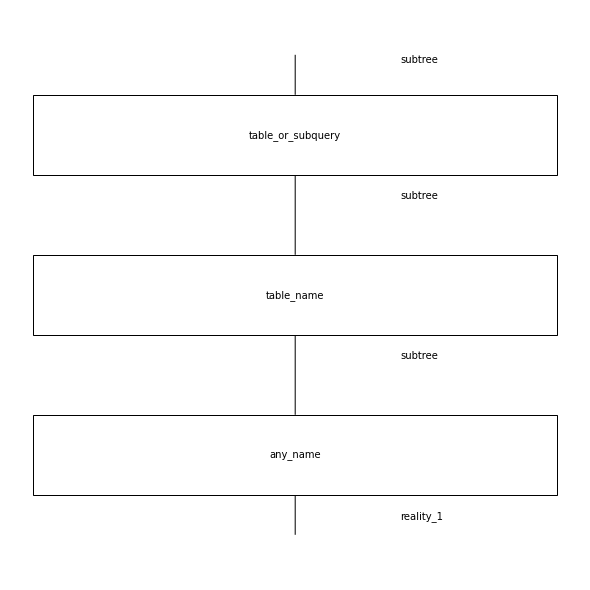

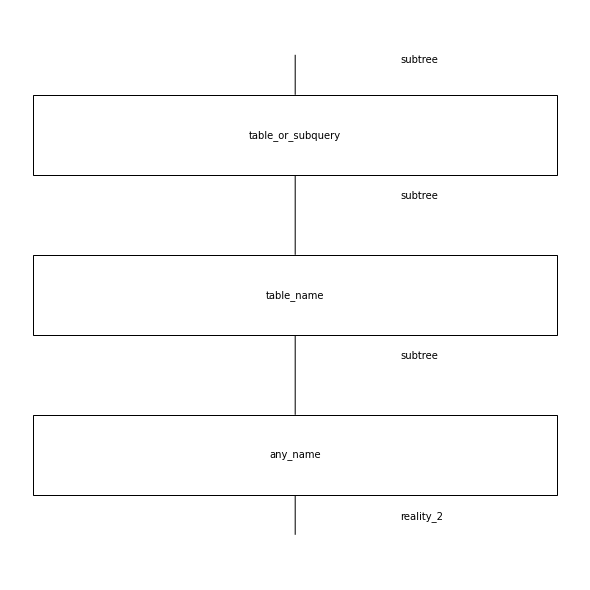

filtering_diagrams


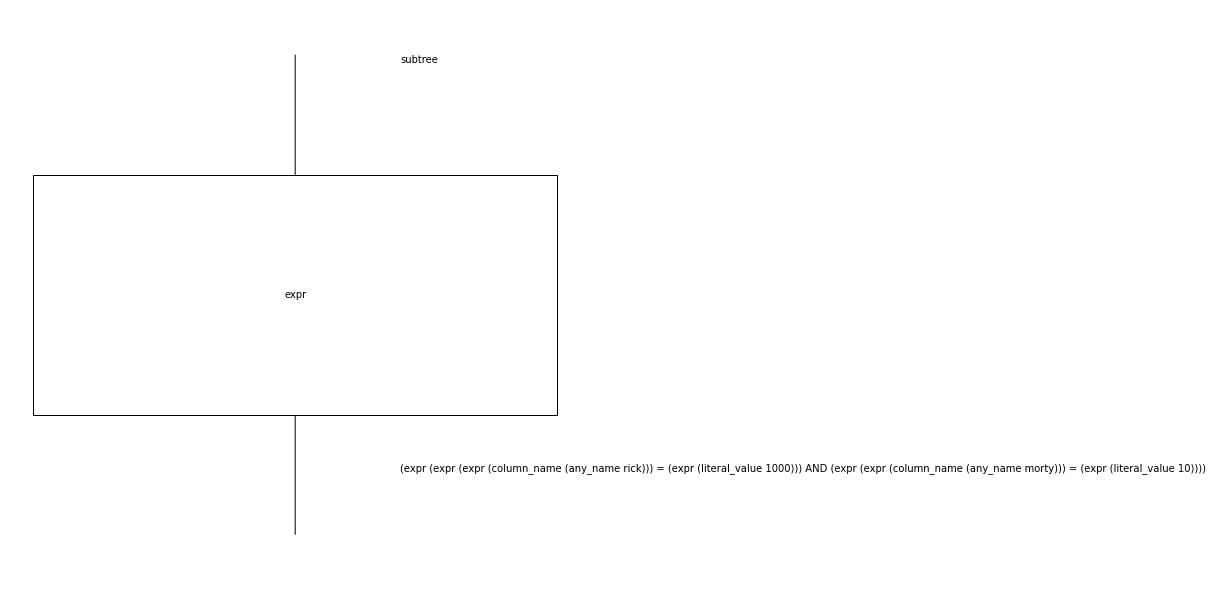

In [2]:
walker = ParseTreeWalker()
listener = SQLiteParserListener(parser)
walker.walk(listener, tree)
diagrams = listener.get_SQL_diagrams()
for key in diagrams:
    print(key)
    for diagram in diagrams[key]:
        diagram.draw(figsize=(8, 8))

Because the abstract syntax tree contains lots of unnecessary information for our purposes, we can functorially rewrite it. We also rename some parts of it. This functorial rewriting process is just something that we have developed especially for this work and it is open to discussion if there exists a more suitable rewrite mapping.

## Functorially map context free grammar representations to pregroup representations

## Convert pregroup representations to circuits